In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import glob
from PIL import Image
from torchvision.utils import make_grid
import os
torch.manual_seed(42)

In [474]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Sample Exercise:

Explore the regularization effects of data augmentation. Use image data
“cats_and_dogs_filtered” and apply random transformations (e.g., rotations, flips, and noise)
to artificially increase the size of the training dataset. Compare the model's performance with
and without data augmentation.

In [ ]:
img = Image.open('sample.png')

In [ ]:
class Gaussian(object):
    def __init__(self, mean: float, var: float):
        self.mean = mean
        self.var = var  
    def __call__(self, img: torch.Tensor) -> torch.Tensor:
        return img + torch.normal(self.mean, self.var, img.size())

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    Gaussian(0,0.15),
])

In [ ]:
class MyDataset(Dataset):
    def __init__(self, transform=None, str="train"):
        self.imgs_path = ".\\data\\cats_and_dogs_filtered\\"+ str + "\\"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            if os.path.isdir(class_path):
                class_name = class_path.split("\\")[-1]
                img_paths = glob.glob(class_path + "\\*.png")
                for img_path in img_paths:
                    self.data.append([img_path, class_name])
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = Image.open(img_path)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)
        if self.transform:
            img = self.transform(img)
        return img, class_id

In [ ]:
dataset = MyDataset(transform=preprocess,str = "train")
dataloader = DataLoader(dataset)

In [ ]:
i=0
for data in iter(dataloader):
    img, _ = data
    img = img.squeeze(0)
    img = make_grid(img)
    tI = transforms.ToPILImage()
    img = tI(img)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    i += 1
    if i == 3:
        break

1. Implement L2 regularization on cat-dog classification neural network. Train the model on the dataset, and observe the impact of the regularization on the weight parameters. (Do not use data augmentation).

        a. L2 regularization using optimizer’s weight decay
        b. L2 regularization using loop to find L2 norm of weights

In [481]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [482]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [483]:
train_dataset = datasets.ImageFolder("/home/student/220962137_DL/Lab6/cats_and_dogs_filtered", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder("/home/student/220962137_DL/Lab6/cats_and_dogs_filtered", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [484]:
model=CatDogCNN().to(device)
model

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [485]:
learning_rate = 0.0001
epochs=10
lambda_l = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l)

In [486]:
def l2_regularization(parameters, lambda_l2):
    l2_norm = 0
    for param in parameters:
        if param.requires_grad:
            l2_norm += torch.sum(param**2)
    return lambda_l2 * l2_norm

In [487]:
def train(model, epochs, train_loader, criterion, optimizer, reg, lambda_l):
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for input, output in train_loader:
            input, output = input.to(device), output.to(device)
            optimizer.zero_grad()
            pred = model(input)
            loss = criterion(pred, output)
            if reg:
                reg_loss = reg(model.parameters(),lambda_l)
            else:
                reg_loss=0
            total_loss = loss + reg_loss
            total_loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        losses.append(running_loss / len(train_loader))
    return losses

In [488]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for input, output in test_loader:
            input, output = input.to(device), output.to(device)
            pred = model(input)
            _, predicted = torch.max(pred, 1)
            total += output.size(0)
            correct += (predicted == output).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")

Epoch 1/10, Loss: 0.6426311965952528
Epoch 2/10, Loss: 0.6407127107711549
Epoch 3/10, Loss: 0.6343932849295596
Epoch 4/10, Loss: 0.6244475163043813
Epoch 5/10, Loss: 0.6165310908505257
Epoch 6/10, Loss: 0.5961913406214816
Epoch 7/10, Loss: 0.5782061482363559
Epoch 8/10, Loss: 0.5522582045894988
Epoch 9/10, Loss: 0.5184644505064538
Epoch 10/10, Loss: 0.48797821554731813


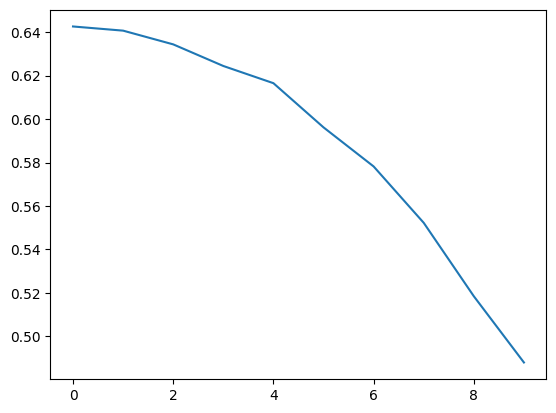

In [489]:
losses=train(model,epochs,train_loader, criterion,optimizer,l2_regularization,lambda_l)
plt.plot(losses)

In [490]:
evaluate(model,test_loader)

Test Accuracy: 78.1%


2. Implement L1 regularization on cat-dog classification neural network. Train the model on the dataset, and observe the impact of the regularization on the weight parameters. (Do not use data augmentation).

        a. L1 regularization using optimizer’s weight decay
        b. L1regularization using loop to find L1 norm of weights

In [491]:
def l1_regularization(parameters, lambda_l1):
    l1_norm = 0
    for param in parameters:
        if param.requires_grad:
            l1_norm += torch.sum(torch.abs(param))
    return lambda_l1 * l1_norm

Epoch 1/10, Loss: 0.47880866806557837
Epoch 2/10, Loss: 0.5040250962719004
Epoch 3/10, Loss: 0.5217061036444725
Epoch 4/10, Loss: 0.5165913177931563
Epoch 5/10, Loss: 0.5146792175921988
Epoch 6/10, Loss: 0.5169228895547542
Epoch 7/10, Loss: 0.4985330944999735
Epoch 8/10, Loss: 0.492225929460627
Epoch 9/10, Loss: 0.47844368504716994
Epoch 10/10, Loss: 0.4655900182242089


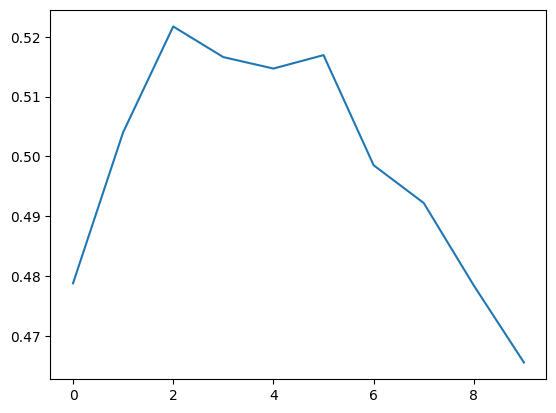

In [492]:
losses=train(model,epochs,train_loader, criterion,optimizer,l1_regularization,lambda_l)
plt.plot(losses)

In [493]:
evaluate(model,test_loader)

Test Accuracy: 79.36666666666666%


3. Implement dropout regularization on cat-dog classification neural network. Train the model with and without dropout on a dataset, and compare the performance and overfitting tendencies.

In [494]:
class CatDogCNNDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)
        

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x=self.dropout(x)
        x = self.fc2(x)
        return x

In [495]:
model_dropout=CatDogCNNDropout().to(device)
model

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 1/10, Loss: 0.6658055661840642
Epoch 2/10, Loss: 0.6663352289098374
Epoch 3/10, Loss: 0.6663331890359838
Epoch 4/10, Loss: 0.666265293638757
Epoch 5/10, Loss: 0.6661567110964592
Epoch 6/10, Loss: 0.6661998179364712
Epoch 7/10, Loss: 0.6658293535100653
Epoch 8/10, Loss: 0.6665542151065583
Epoch 9/10, Loss: 0.6662345763216627
Epoch 10/10, Loss: 0.6661494792775905


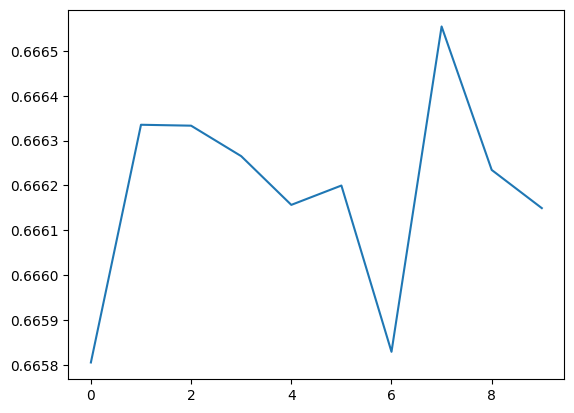

In [496]:
losses = train(model_dropout, epochs, train_loader, criterion, optimizer,l2_regularization,lambda_l)
plt.plot(losses)

In [497]:
evaluate(model_dropout, test_loader)

Test Accuracy: 66.66666666666667%


4. Implement your own version of the dropout layer by using Bernoulli distribution and compare the performance with the library.

In [498]:
class CustomDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p=p
        
    def forward(self, x):
        if self.training:
            mask=torch.bernoulli(torch.full_like(x,1-self.p)).float()
            x = x*mask
            x=x/(1-self.p)
        return x

In [499]:
class CatDogCNNDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.dropout = CustomDropout(0.5)
        self.fc2 = nn.Linear(128, 2)
        

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x=self.dropout(x)
        x = self.fc2(x)
        return x

In [500]:
model_dropout=CatDogCNNDropout().to(device)
model

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 1/10, Loss: 0.7061766557236935
Epoch 2/10, Loss: 0.7056119822441264
Epoch 3/10, Loss: 0.7059161130418169
Epoch 4/10, Loss: 0.7062028931810501
Epoch 5/10, Loss: 0.70667040031007
Epoch 6/10, Loss: 0.70588921422654
Epoch 7/10, Loss: 0.7062076209707463
Epoch 8/10, Loss: 0.7062296284005997
Epoch 9/10, Loss: 0.7063899686995972
Epoch 10/10, Loss: 0.705643356480497


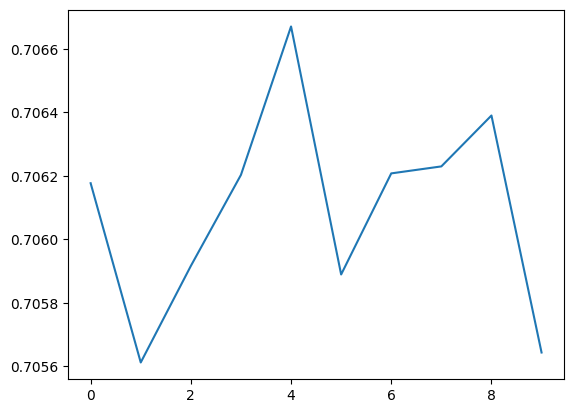

In [501]:
losses = train(model_dropout, epochs, train_loader, criterion, optimizer,l2_regularization,lambda_l)
plt.plot(losses)

In [502]:
evaluate(model_dropout, test_loader)

Test Accuracy: 33.333333333333336%


5. Implement early stopping as a form of regularization. Train a neural network and monitor the
validation loss. Stop training when the validation loss starts increasing, and compare the
performance with a model trained without early stopping.

In [503]:
patience = 5
best_validation_loss = float('inf')
current_patience = 0

In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader)}')

    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

        validation_loss /= len(test_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {validation_loss}')

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        current_patience = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model saved with validation loss: {best_validation_loss}")
    else:
        current_patience += 1

    if current_patience >= patience:
        print(f"Early stopping! No improvement for {patience} epochs.")
        break


Epoch [1/10], Training Loss: 0.45949427085988065
Epoch [1/10], Validation Loss: 0.4131165089759421
Model saved with validation loss: 0.4131165089759421
Epoch [2/10], Training Loss: 0.41958675390862404
Epoch [2/10], Validation Loss: 0.36631606614336054
Model saved with validation loss: 0.36631606614336054
Epoch [3/10], Training Loss: 0.39326271224529186
